# ICDM Proposed Reward Distributions

Developers of the NFT project, Internet Computer Personal Computers, have recently set a vote to allow the community to decide a reward mechanism for holders.  Each month, 5% of the secondary market trades will be allocated to a pool and disbursed to holders in one of two ways.  The two options are:

* A: ICP tokens paid out based on your weighted stake
    * weight calculated as `7777 * 2 * NRI (NFT Rarity) + 7777`
    * payout proportional to your share of the total stake, or the sum of your weighted scores for each NFT
* B : Raffle entries for weighted stake
    * same weight calc as above, allocated as "tickets" and a multiplier is applied for number held in the same wallet (instead of sum)
    * by winning the drawing your ticket allocation for the next round is halved
    * all losers' ticket allocations are multiplied by 1.5 for the next round
    * ticket amounts compound, accruing across rounds
    * number of NFT's awarded are based on the pool allocation from a 5% tax on all transactions, with the devs buying as many as possible at the current floor

I thought this might be an interesting opportunity to see what the odds were based on actual wallet data. I also suggested a different formula whcih I believed might be a little fairer: `Mean NRI score * (# NFTs / 7777) * Number of consecutive raffle periods` with the idea being more emphasis is placed on holding a larger number of more rare NFT's and receiving a greater bonus for participating in consecutive rounds.  My major concern was with Whale wallets being able to unfairly game the system by playing with the probabilities of winning to unfairly maximize their odds.  Below I'll explore that idea by scraping current ICPC wallet data from DGastonia.com, running a 5 year simulation, and plotting the odds of victory with a few assumptions:
* highest probability wins that round
* awarded NFT's are not added to the winner's wallet (estimating NFT rewards would be hard with limited history)
* ALL NFT's in each wallet are staked

Basically, taking a snapshot in time, how long would it take for the game to become fair for all players?

### Building the dataset

BeautifulSoup and Pandas will help to pull in the data as we have most of what we need on dgastonia, number of holdings and the TI^ (probability of minting with those traits) that each wallet holds.  Unfortunately I am not sure on how to actually pull this data directly from the ICP blockchain, but I hope in the future to learn and potentially iterate on this project!

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

url = 'https://www.dgastonia.com/nfts/collections/icpcs/registry'

page = requests.get(url)

soup = BeautifulSoup(page.content, "html.parser")

### Account Holdings

We can start by fetching a summary of account holdings from dgastonia, thankfully this is formatted already pretty nicely so it will be easy to scrape into a single dataframe.  

In [22]:
# get holdings by account
table = soup.table.prettify()
accounts = pd.read_html(table)[0]
accounts

,Account,Count,Percent,Floor value
0,…ff2188,202,2.6%,500.96
1,…d4010e,197,2.53%,488.56
2,…87339d,167,2.15%,414.16
3,…d23f51,160,2.06%,396.80
4,…77b94d,152,1.95%,376.96
...,...,...,...,...
1276,…292ad6,1,0.01%,2.48
1277,…769a3a,1,0.01%,2.48
1278,…50b6f2,1,0.01%,2.48
1279,…d0759b,1,0.01%,2.48


### Average Rarity

Next we need to pull in the average rarity by wallet holding. This will be a little bit trickier to do as the metric used on Entrepot, NRI (NFT Rarity Index) is not easily accessible nor used on the site we're scraping.  Instead we have DTI (Dominant Trait Index), TI (Trait Index) and TI^ (Exponential Trait Index).  Given each of these metrics is a little different, and differs from NRI, we can collect each of these and then use the metric we feel is most closely related to what we're measuring.  Since TI^ is the statistical proability of minting the NFT with those traits, we can use that as a proxy until I can pull in NRI reliably.  

Given there are no `id` or `class` attributes in the HTML being scraped, we can use the fact that all three metrics will be pulled into a single list and then use mod 3 on the index of the value in the list to categorize them into their respective metric buckets (first is DTI, second is TI, third is TI^ and then it repeats).  

In [23]:
# get average rarity by account
base_url = 'https://www.dgastonia.com'

def get_rarity(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    rarity_list = soup.find_all('span','percentIndex')
    rarities = []
    for x in rarity_list:
        rarities.append(float(x.text))
    return rarities

In [27]:
avg_nri = {}
for i, account in enumerate(soup.table.find_all('a')): # find all links in the table
    account_link = base_url + account.attrs.get('href') # get reference links to unique wallet pages
    all_rarities = []
    page = 1 # initialize page 1
    while True:
        if page == 1:
            all_rarities += get_rarity(account_link)
            page += 1
        elif page != 1:
            next_page = account_link + f'&page={page}' # add page 2+ to URL 
            next_rarity = get_rarity(next_page)            
            if next_rarity == []: # exit loop if no data found on page
                break
            all_rarities += next_rarity
            page += 1
                    
    dti = []
    ti = []
    ti_exp = []
    for index, value in enumerate(all_rarities):
        if index % 3 == 0:
            dti.append(value)
        elif index % 3 == 1:
            ti.append(value)
        else:
            ti_exp.append(value)
            
    acc_no = account.text.strip()
    avg_nri[acc_no] = {
        'dti': np.mean(dti),
        'all_dti': dti,
        'ti': np.mean(ti),
        'all_ti': ti,
        'ti_exp': np.mean(ti_exp),
        'all_ti_exp': ti_exp
    }
    print(f'pages parsed: {(page-1)} for account: {acc_no}, {i / (len(accounts)-1):.2%} finished', end='\r')

In [28]:
# save data to json file
data_json = os.path.join(os.getcwd(), 'data_json.json')
with open(data_json, 'w') as file:
    json.dump(avg_nri, file)
# assign ti_exp to a dict by acct
avg_ti_exp = {v: avg_nri[v]['ti_exp'] for v in avg_nri}

In [29]:
nri_df = pd.DataFrame.from_dict(avg_ti_exp, orient='index').reset_index()
nri_df.rename(columns = {
    "index":"Account",
    0:"Mean NRI"
}, inplace=True)
nri_df

holders = pd.merge(accounts, nri_df, on='Account')

# create initial ticket values based on dev formula
def init_tickets(df):
    return (7777*2*df[1]+7777)*df[0]

# apply to create new column
holders['Initial Tickets'] = holders[['Count','Mean NRI']].apply(init_tickets,axis=1)
holders

,Account,Count,Percent,Floor value,Mean NRI,Initial Tickets
0,…ff2188,202,2.6%,500.96,47.296040,1.501708e+08
1,…d4010e,197,2.53%,488.56,39.980102,1.240366e+08
2,…87339d,167,2.15%,414.16,45.120958,1.185013e+08
3,…d23f51,160,2.06%,396.80,51.457233,1.293028e+08
4,…77b94d,152,1.95%,376.96,59.240132,1.412381e+08
...,...,...,...,...,...,...
1276,…292ad6,1,0.01%,2.48,44.500000,6.999300e+05
1277,…769a3a,1,0.01%,2.48,56.900000,8.927996e+05
1278,…50b6f2,1,0.01%,2.48,34.700000,5.475008e+05
1279,…d0759b,1,0.01%,2.48,42.500000,6.688220e+05


In [30]:
# store data in SQL file for easier access, refresh the db
db = os.path.join(os.getcwd(), 'holders.sqlite3')
con = sqlite3.connect(db)
holders.to_sql('holders',con,if_exists="replace",index=False) 

1281

In [10]:
# run from this cell down instead of re-scraping every time.
db = os.path.join(os.getcwd(), 'holders.sqlite3')
con = sqlite3.connect(db)
holders = pd.read_sql("SELECT * FROM holders",con=con)
con.close()
holders.head(20)

,Account,Count,Percent,Floor value,Mean NRI,Initial Tickets
0,…ff2188,202,2.6%,500.96,47.296040,1.501708e+08
1,…d4010e,197,2.53%,488.56,39.980102,1.240366e+08
2,…87339d,167,2.15%,414.16,45.120958,1.185013e+08
3,…d23f51,160,2.06%,396.80,51.457233,1.293028e+08
4,…77b94d,152,1.95%,376.96,59.240132,1.412381e+08
5,…836d79,114,1.47%,282.72,61.198246,1.094006e+08
6,…362777,106,1.36%,262.88,29.909434,5.013676e+07
7,…358e40,99,1.27%,245.52,61.274747,9.512360e+07
8,…23cc44,92,1.18%,228.16,47.465217,6.863669e+07
9,…e06d13,90,1.16%,223.20,52.962222,7.483963e+07


## Ticket Values by Account

Below is a chart showing the initial ticket amounts for each account, sorted descending by number of NFT's in account.  This should give an idea of how the tickets are distributed across different holders.  It's important to keep in mind that one individual is likely to hold their NFT's across several wallets, which may even allow them to game the raffle down the line.

Text(0.5, 1.0, 'Distribution of Ticket Amounts by Account')

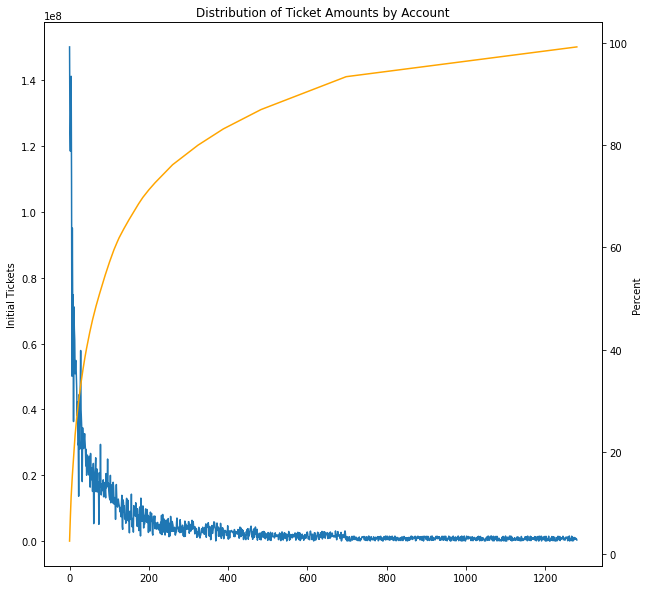

In [32]:
%matplotlib inline

pct_int = holders['Percent'].str.strip('%').astype('float')

plt.figure(figsize=(10,10))
sns.lineplot(x=holders.index,y=holders['Initial Tickets'])
ax2 = plt.twinx()
sns.lineplot(x=holders.index, y=pct_int.cumsum(),ax=ax2,color='orange')
plt.xlabel('Account Number sorted by NFTs held')
plt.title('Distribution of Ticket Amounts by Account')

## Simulating Raffle Game

To simulate this, we will create a function applied to a sliding window of time where each row represents a new monthly raffle and each column is a unique wallet address.  To reiterate how this simulation works which may differ from reality, here are some assumptions:
* only one wallet wins
* the highest probability wins
* NFT's are not added to the winner's staked pool
* the entire wallet holding is staked

The model will be run for a 5 year timeframe and we should be able to extract the point at which probabilities of winning converge so that all participants have an equal chance of winning.  We should also be able to extract the rate at which wallets converge based on number of NFT's held and their average rarity. 

In [40]:
def run_sim(df):
    """
    Takes DataFrame of Accounts and returns 60 drawings based on the dev ticket calculation
    """
    sim = pd.DataFrame(index=range(60), columns=df['Account'])
    
    i_tix = df['Initial Tickets']
    
    # initial ticket values by wallet
    sim.iloc[0] = i_tix
    
    # return 1.5x multiplier for all holders (50% rollover) and cut winner's odds in half
    for i in range(59):
        sim.iloc[i+1] = sim.iloc[i] * 1.5
        sim.iloc[i+1] = sim.iloc[i+1].apply(lambda x: x / 3 if x == max(sim.iloc[i+1]) else x)
    
    return sim

def get_probabilities(sim):
    """
    Takes ticket values calculated in sim and returns the probabiliies
    """
    for i in range(60):
        sim.iloc[i] = sim.iloc[i].apply(lambda x: (x / sum(sim.iloc[i])*100))
    return sim
        
sim = run_sim(holders)
winners = get_probabilities(sim)

<AxesSubplot:>

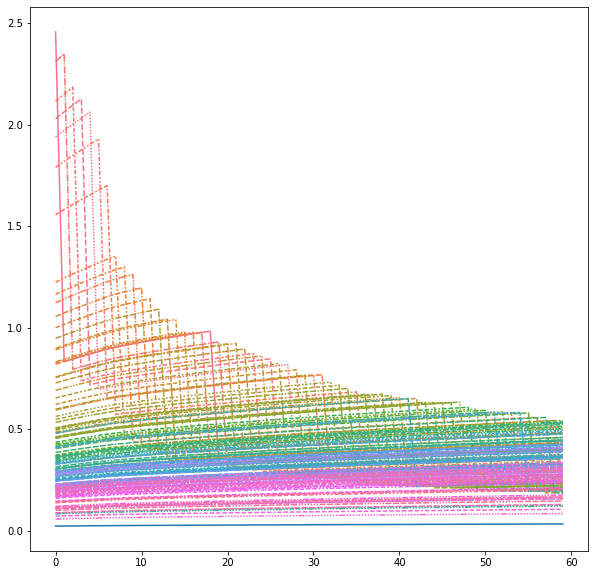

In [34]:
%matplotlib inline

#plot the min, 25%, 50%, 75%, and largest holder over the course of the sim
def sample_accounts(holders):
    _min = holders[holders['Initial Tickets'] == holders['Initial Tickets'].min()]['Account'].values[0]
    _25th = holders[holders.index == round(len(holders)*.25)]['Account'].values[0]
    _50th = holders[holders.index == round(len(holders)*.5)]['Account'].values[0]
    _75th = holders[holders.index == round(len(holders)*.75)]['Account'].values[0]
    _max = holders[holders['Initial Tickets'] == holders['Initial Tickets'].max()]['Account'].values[0]
    return _min, _max, _25th, _50th, _75th
l,h,t,f,s = sample_accounts(holders)
plt.figure(figsize=(10,10))
plt.plot(winners.median(axis=1))

sns.lineplot(data=winners.iloc[:,:150],legend=False)

The chart above shows the probability of winning for the top 200 wallets over 5 years, the bottom line below shows the median victory probability for all wallets.  We can observe a few things with this:
* over a long enough time, all wallets are converging towards equal probability of winning
* larger wallets are decaying faster than smaller wallets are increasing in probability (in general)
* the maximum winning odds are decaying logarithmically 

We can extract a function to tell us the rate at which the maximum probability decays

Y=1.91 * e^(-0.102 * x) + 0.617


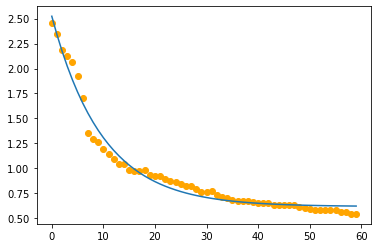

In [61]:
%matplotlib inline
from scipy.optimize import curve_fit

# exponential decay function
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

x=range(len(winners))
popt, pcov = curve_fit(exp_decay, x,winners.max(axis=1))
a,b,c = popt

plt.plot(x,exp_decay(x,*popt))
plt.scatter(x=x,y=winners.max(axis=1),color='orange')
print(f'Y={a:.3} * e^(-{b:.3} * x) + {c:.3}')

From here, though we know the rate of decay, how can we use the information here to actually maximize our odds?  We know that frontloading all NFT's into a single wallet will just cause the probability of winning to rapidly decay and minimize our overall chances of winning.  Secondly, it wouldn't allow us to take advantage of the fact that a number of NFT's are being awarded on the first round, since our wallet can only win a single time.

Our overall strategy to maximize return and minimize the loss in odds incurred by winning a round would be to create a certain number of wallets that have the right number of NFT's and right average rarity that the sum of their probabilities would be the highest value possible. 

There are two possible approaches: 
1) create one wallet per NFT

2) tune the probability of several wallets to the asymptote of the decay function 

Both should initially create an equal sum of odds for the holder, however over the longer term I would expect the second strategy to perform better because it can take advantage of compounding and the individual wallet odds will be close to the equilibrium point, as well as minimizing the impact of diluting the competition pool which would have the effect of lengthening the time it takes for all probabilities to converge.  From the function we found above of the maximum potential return (based on one victory/raffle), we can use `binpacking` to approximately match the ticket holdings required to meet the equlibrium point, this would be based off of number of NFT's and rarity required to meet a certain threshold of tickets.   

### Strategy 1: 1 NFT Per Wallet

In [63]:
with open((os.path.join(os.getcwd(),'data_json.json'))) as file:
    data = json.load(file)
# take top wallet
top_wallet = data[holders.iloc[0,0]]['all_ti_exp']
# create named df cols with ticket amounts
spread_wallet = {}
for i, v in enumerate(top_wallet):
    name = f"whale_{i}"
    spread_wallet[name] = 7777 * 2 * v + 7777
# convert to df
spread_df = pd.DataFrame.from_dict(spread_wallet,orient='index').reset_index()
spread_df.rename(columns={
    "index":"Account",
    0:"Initial Tickets"
},inplace=True)
# from main df, drop top wallet to replace with spread wallets
new_holders = holders[['Account','Initial Tickets']].iloc[1:,:].copy()
# combine DataFrames
combined = pd.concat([spread_df,new_holders])
# run sim and extract probabilities for the new data
spread_sim = run_sim(combined)
spread_probs = get_probabilities(spread_sim)

,Account,Initial Tickets
0,whale_0,1560066.2
1,whale_1,1404526.2
2,whale_2,1494739.4
3,whale_3,1401415.4
4,whale_4,1491628.6
...,...,...
197,whale_197,76214.6
198,whale_198,200646.6
199,whale_199,94879.4
200,whale_200,15554.0


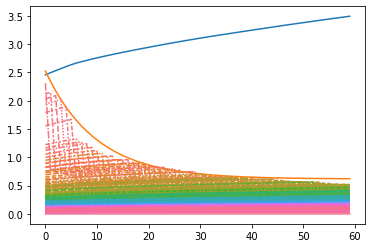

In [73]:
%matplotlib inline
whale_probability = spread_probs[spread_df['Account']].sum(axis=1)
sns.lineplot(x=range(len(whale_probability)),y = whale_probability)
plt.plot(x,exp_decay(x,*popt))
sns.lineplot(data=spread_probs.iloc[:,201:500], legend=False)
plt.show()

We can see based on the above that the sum of probabilities for the whale's wallets will tend to increase over time as there is a far greater gain in tickets from the number of wallets losing the raffle than from potentially winning, and while in general, the maximum odds for the stacked wallets will be always converging downwards, the whale's chances of winning diverge significantly from the decay curve.  

### Strategy 2: Optimize Probabilities of Bucketed Wallets

This strategy will be a little bit harder to code for, as we'll have to work backwards to try and figure out how to best spread out the NFT's into different wallets so that their rarity and number held will net about the same number of tickets at some sort 